# Comparing ADAM to MCMC

## Bayesian Optimization (BO)

In BO we have an objective function, $f(x)$, the function we want to maximize, we assume $f: \mathcal{X} \to \mathbb{R}$.

### Introduction
This notebook aims to illustrate the existing functionality in BoTorch for different methods of handling the hyperparameters of a gaussian process surrogate model in BO. We will ignore different surrogate models, but both methods are generally suitable for any parametric surrogate models.

In BO there are two major components that determined the efficacy of the algorithm the surrogate model(s), and acquisition function. The surrogate model(s) give a predictive distribution, $P_\mathcal{M}(x)$ which we ideally want to be as close to the objective function as possible. The acquisition function determines the next evaluation point based off of the surrogate model.


In Bayesian Optimization for an arbitrary acquisition function we wish to find the $arg\:max_{x \in \mathcal{X}} \alpha(x \mid \theta)$. We can and often do choose $\theta$ through an optimizer (e.g. ADAM), $\theta$ that gives the max value of (Eq. 3). Alternatively we can take a bayesian approach to the likelihood function and consider the distribution of $\theta$ such that we now wish to find.
$$
arg\:max_{x\in\mathcal{X}} \int_\Theta \alpha(x\mid\theta, X, )L(\theta \mid X, \textbf{y})\,d\theta
\tag{1}
$$
This integral is of course intractable, a very popular way of approximating intractable integrals is monte carlo methods the most commonly used monte carlo methos is Markov Chain Monte Carlo (MCMC). 

The conclusion which we aim to draw in the remainder of the notebook is that the approximation of (1) through MCMC leads to better evaluations of an objective function than choosing $\theta$ to be a single value found through an optimizer. This conclusion is one that is supported in the literature.

### Gaussian Processes (GPs)
**Important Note** It is not neccessary to follow the maths in this section the only important takeaways are, **1.** a GP is defined by a kernel, **2.** a kernel's performace is dependant on hyperparameters $\theta$, **3.** there exists a likelihood equation (Eq. 3) which defines how well a kernel fits the data, **4.** there is closed form equation for the gradient of this likelihood equation (Eq. 4).


A GP is a kernel based modelling method for set of points $X = [\textbf{x}_1, \dots, \textbf{x}_n]$, $\textbf{x}_i \in \mathcal{X},\; \forall i \in \{1,\dots,n\}$ with a corresponding vector $\textbf{y} = [y_1, \dots , y_n],\; y_i = f(\textbf{x}_i),\; \forall i \in \{1,\dots,n\}$. A kernel function $k: \mathcal{X} \times \mathcal{X} \to \mathbb{R}$ defines the believed similarity between two points. Where $K_{XX}$ is a matrix $\mathbb{R}^{n\times n}$, with $[K_{XX}]_{ij} = k(\textbf{x}_i, \textbf{x}_j)$

A simple example of a kernel function is a Radial Basis Function (RBF) with 
$$k(\textbf{x}, \textbf{x}') = \exp\left(-\frac{\lVert \textbf{x}- \textbf{x}' \rVert}{2l^2}\right) 
\tag{2}
$$
Allow $\theta$ to be a vector of hyperparameters in the case of an RBF kernel $\theta = [l]$ but generally more complex kernel functions will have more than one hyperparameter, all of which need tuning. Using a hat to denote an added diagonal of noise, $\hat{K}_{XX} = K_{XX} + \sigma_n^2\textbf{I}$, we have an additional tunable parameter (now $\theta = [l, \sigma_n]$) we can write the log marginal likelihood equation as
$$
L(\theta \mid X, \textbf{y}) \propto log\lvert \hat{K}_{XX}\rvert - \textbf{y}^T\hat{K}_{XX}^{-1}\textbf{y},
\tag{3}
$$
$$
\frac{dL}{d\theta} = \textbf{y}^T\hat{K}_{XX}^{-1}\frac{\hat{K}_{XX}}{d\theta}\hat{K}_{XX}^{-1}\textbf{y} + Tr\left(\hat{K}_{XX}^{-1}\frac{\hat{K}_{XX}}{d\theta}\right),
\tag{4}
$$
With $Tr(\cdot)$ as the trace. 



## MCMC
### Explanation
Markov Chain Monte Carlo (MCMC) is a class of algorithms for inferring / exploring a probability distribution. In its simplest implementation we have some target distribution $\pi(x)$ and we can explore this distribution by considering a chain of point vectors starting at $x_0$, we then propose a new point $x^*  \sim q(x^* \mid x_{t})$ where $q$ is the proposal distribution which can be as simple as $\mathcal{N}(0, \textbf{I})$ and then the new point is accepted or rejected in accordance with an acception probability:
$$
\alpha(x_t,\,x^*) = min\left[1,\, \frac{\pi(x^*)q(x_t\mid x^*)}{\pi(x)q(x^*\mid x_t)}\right]
$$
As an algorithm:
$$
\begin{aligned}
&\textbf{Inputs: } x_0,\, q(\cdot),\, n_{iters} \\
&\textbf{for } t = \{0, \dots, n_{iters}-1\}: \\
&\quad x^* \sim q(x_t) \\
&\quad u \sim \text{Uniform}[0,1) \\
&\quad x_{t+1} =
\begin{cases}
x^*\,, & \text{if}\;\; \alpha(x_t, x^*) > u \\
x_t\,, & \text{otherwise}
\end{cases}
\end{aligned}
$$

### Example

All this basically means is given enough iterations, and an appropriate proposal distribution (which can be gradient based) we can infer a target probability distribution just by looking at a histogram of the points visited in the chain, this is showed in the code below:

(a caveat being that if our initial proposal $x_0$ is bad early samples should be thrown out, referred to as burn-in or warm-up steps)

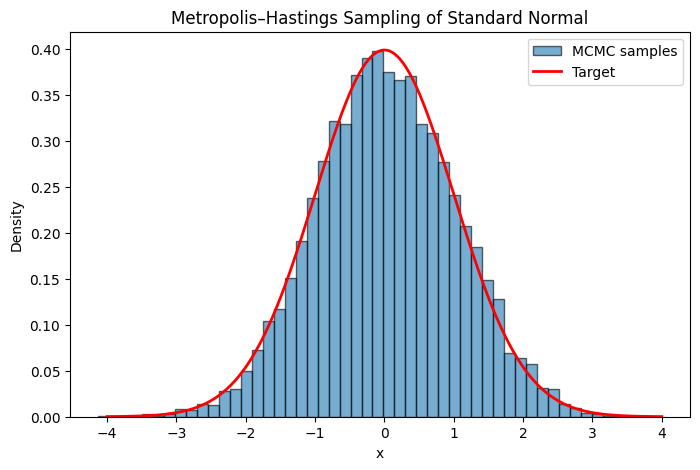

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def target_pdf(x):
    """Standard normal probability density function."""
    return norm.pdf(x, loc=0, scale=1)

def propose(x, proposal_std=1.0):
    """Propose a new point from a Normal(x, proposal_std^2)."""
    return np.random.normal(x, proposal_std)

def acceptance_prob(x, x_prop):
    """Compute Metropolis-Hastings acceptance probability."""
    return min(1, target_pdf(x_prop) / target_pdf(x))

def run_mcmc(n_samples=10000, x0=0.0, proposal_std=1.0):
    samples = np.zeros(n_samples)
    x_current = x0
    for i in range(n_samples):
        x_prop = propose(x_current, proposal_std)
        alpha = acceptance_prob(x_current, x_prop)
        if np.random.rand() < alpha:
            x_current = x_prop  # accept move
        samples[i] = x_current
    return samples

np.random.seed(42)
samples = run_mcmc(n_samples=20000, x0=0.0, proposal_std=1.0)

x_grid = np.linspace(-4, 4, 400)
plt.figure(figsize=(8, 5))
plt.hist(samples, bins=50, density=True, alpha=0.6, label="MCMC samples", edgecolor='black', linewidth = 1.0)
plt.plot(x_grid, target_pdf(x_grid), 'r-', lw=2, label="Target")
plt.title("Metropolis–Hastings Sampling of Standard Normal")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()

# BO with MCMC

## Implementation

After choosing a kernel we can express the likelihood of a set of hyperparameters with $L(\theta \mid X, \textbf{y})$. For MCMC
we can draw $\theta_0$ from a proposal distribution, and then explore the likelihood by running an MCMC algorithm (the likelihood is the target distribution $\pi(x)$). Each MCMC iteration we build a new GP and assess the likelihood of the hyperparameters. After running the MCMC algorithm we construct our surrogate model from these samples, starting from samples at iteration $k$ where samples before $k$ are discarded to avoid biasing our estimator with the proposal distribution.

Using the notation that for a set of hyperparameters $\theta_i$, the probability density function returned by the GP is $P_{\theta_i}(x) = \mathcal{N}(\mu_{\theta_i}(x), \sigma^2_{\theta_i}(x))$, Our surrogate model resulting from running MCMC for $n$ iterations is:
$$
P_\mathcal{M}(x) = P_{\theta_k}(x) + P_{\theta_{k+1}}(x) + \dots + P_{\theta_{n}}(x)
$$
Meaning our predictor for $x \in \mathcal{X}$ is a **gaussian mixture** not a normal distribution.

## Acquisition Functions in BoTorch

There has been some discussion recently in the role of Monte-Carlo in BoTorch as it relates to acquisiton functions, this application of Monte-Carlo is seperate from the technique discussed above

## Preamble Code

We begin with defining a dataset class for readability the specifics of the class are not important, it just handels the storing of evaluations of the sythetic objective functions.

In [ ]:
import torch
from tests.target_functions import BaseTarget

class Dataset():
    def __init__(
            self, 
            target: BaseTarget,
        ) -> None:
        self.target = target
        self.X: torch.Tensor | None = None
        self.y: torch.Tensor | None = None
        return

    def random_evals(
            self, 
            seed: int, 
            n_iters: int
        ) -> None:
        assert self.X is None and self.y is None
        random_gen = torch.Generator().manual_seed(seed)
        rand_vals = torch.rand(size = (n_iters, self.target.dim), 
                               generator=random_gen)
        X = self.target.bounds[0] + (self.target.bounds[1]-self.target.bounds[0]) * rand_vals
        y = torch.tensor([self.target.sample(x) for x in X])
        self.X = X
        self.y = y.reshape(-1, 1)

    def eval_x(
            self,
            x_star: torch.Tensor,
    ) -> None:
        y_star = self.target.sample(x_star)
        self.X = torch.cat((self.X, x_star.unsqueeze(0)))
        self.y = torch.cat((self.y, y_star.reshape((-1,1))))
        return

For the target functions used visit `tests > target_functions` for declarations, or see [botorch docs](https://botorch.readthedocs.io/en/latest/test_functions.html) for information on the target funcitons, the dimensions used for each will be indicated on any plots generated.

## Main Code 

In [3]:
MODEL_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from botorch.models import SingleTaskGP, SaasFullyBayesianSingleTaskGP

from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll, fit_fully_bayesian_model_nuts, ExactMarginalLogLikelihood
from botorch.acquisition import LogExpectedImprovement
from botorch.optim import optimize_acqf

from tqdm import tqdm
import pickle

import os

def ADAM_BO(
        target: BaseTarget,
        seed: int,
        n_random_evals: int,
        n_bo_evals: int,
        disable_prog_bar: bool = True,
        save_results: bool = True
    ) -> dict:
    assert target.num_evals == 0, 'target must not have been evaluated'
    
    dataset = Dataset(target)
    dataset.random_evals(seed, n_random_evals)

    for _ in tqdm(range(n_bo_evals), 
                  disable = disable_prog_bar):
        gp = SingleTaskGP(train_X=dataset.X,
                          train_Y=dataset.y,
                          input_transform=Normalize(d=target.dim),
                          outcome_transform=Standardize(m=1),)
        gp.to(MODEL_DEVICE)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        logEI = LogExpectedImprovement(model=gp, best_f=dataset.y.max())
        x_star, acq_val = optimize_acqf(logEI, bounds=target.bounds, q=1, num_restarts=5, raw_samples=20)
        x_star = x_star[0]
        dataset.eval_x(x_star)

    results = target.get_results()

    if save_results:
        save_name = f'data/notebook_plot_data/{target.target_name}_ADAM.pkl'

        with open(save_name, "wb") as f:
            pickle.dump(results, f)

    return results

def MCMC_BO(
        target: BaseTarget,
        seed: int,
        n_random_evals: int,
        n_bo_evals: int,
        warm_up_steps: int,
        num_samples: int,
        thinning: int,
        disable_prog_bar: bool = True,
        save_results: bool = True,
    ) -> dict:
    assert target.num_evals == 0, 'target must not have been evaluated'
    
    dataset = Dataset(target)
    dataset.random_evals(seed, n_random_evals)

    for _ in tqdm(range(n_bo_evals), 
                  disable = disable_prog_bar):
        model = SaasFullyBayesianSingleTaskGP(
            train_X=dataset.X,
            train_Y=dataset.y,
            input_transform=Normalize(d=target.dim),
            outcome_transform=Standardize(m=1),)
        model.to(MODEL_DEVICE)
        fit_fully_bayesian_model_nuts(
            model = model,
            warmup_steps=warm_up_steps,
            num_samples=num_samples,
            thinning=thinning,
            disable_progbar=True,
        )
        logEI = LogExpectedImprovement(model=model, best_f=dataset.y.max())
        
        x_star, acq_val = optimize_acqf(logEI, bounds=target.bounds, q=1, num_restarts=5, raw_samples=20)
        x_star = x_star[0]
        dataset.eval_x(x_star)

    results = target.get_results()

    if save_results:
        save_name = f'data/notebook_plot_data/{target.target_name}_MCMC.pkl'

        with open(save_name, "wb") as f:
            pickle.dump(results, f)

    return results

## Test Running

In [ ]:
%%capture output
import time
from tests.target_functions import Ackley, Branin, Hartmann, Rosenbrock

N_RANDOM_EVALS = 10
N_BO_EVALS = 50
SEED = 1

target_classes: list[BaseTarget] = [Ackley, Branin, Hartmann, Rosenbrock]
test_fns: list[callable] = [ADAM_BO, MCMC_BO]
# arguments common accross both test functions
common_args: dict = {'n_random_evals': N_RANDOM_EVALS, 'n_bo_evals': N_BO_EVALS, 'seed': SEED}

# MCMC takes extra args the number of MCMC iterations is warm_up_steps + num_samples
# a thinning of 1 means all of num_samples are used to infer L(\theta)
test_args: list[dict] = [{}, {'warm_up_steps': 256, 'num_samples': 128, 'thinning': 1,}]

results_text = []
for target_class in target_classes:
    for i, test_fn in enumerate(test_fns):
        target: BaseTarget = target_class()
        start_time = time.time()
        test_fn(target = target, **common_args, **(test_args[i]))
        end_time = time.time()
        
        text_line = f'{test_fn.__name__} took {end_time-start_time:.2f} seconds to run on the {target.dim}' \
                    f' dimensional {target.target_name} synthetic test function'
        results_text.append(text_line)
        print(text_line)

Ouput:

Output for 10 random evalus and 50 iterations of bayesian optimization loop:\
```ADAM_BO took 66.36 seconds to run on the 10 dimensional ackley10 synthetic test function```\
```MCMC_BO took 1648.16 seconds to run on the 10 dimensional ackley10 synthetic test function```\
```ADAM_BO took 16.81 seconds to run on the 2 dimensional branin2 synthetic test function```\
```MCMC_BO took 1002.92 seconds to run on the 2 dimensional branin2 synthetic test function```\
```ADAM_BO took 41.46 seconds to run on the 6 dimensional hartmann6 synthetic test function```\
```MCMC_BO took 1187.25 seconds to run on the 6 dimensional hartmann6 synthetic test function```\
```ADAM_BO took 30.52 seconds to run on the 4 dimensional hartmann4 synthetic test function```\
```MCMC_BO took 1146.84 seconds to run on the 4 dimensional hartmann4 synthetic test function```


## Plotting

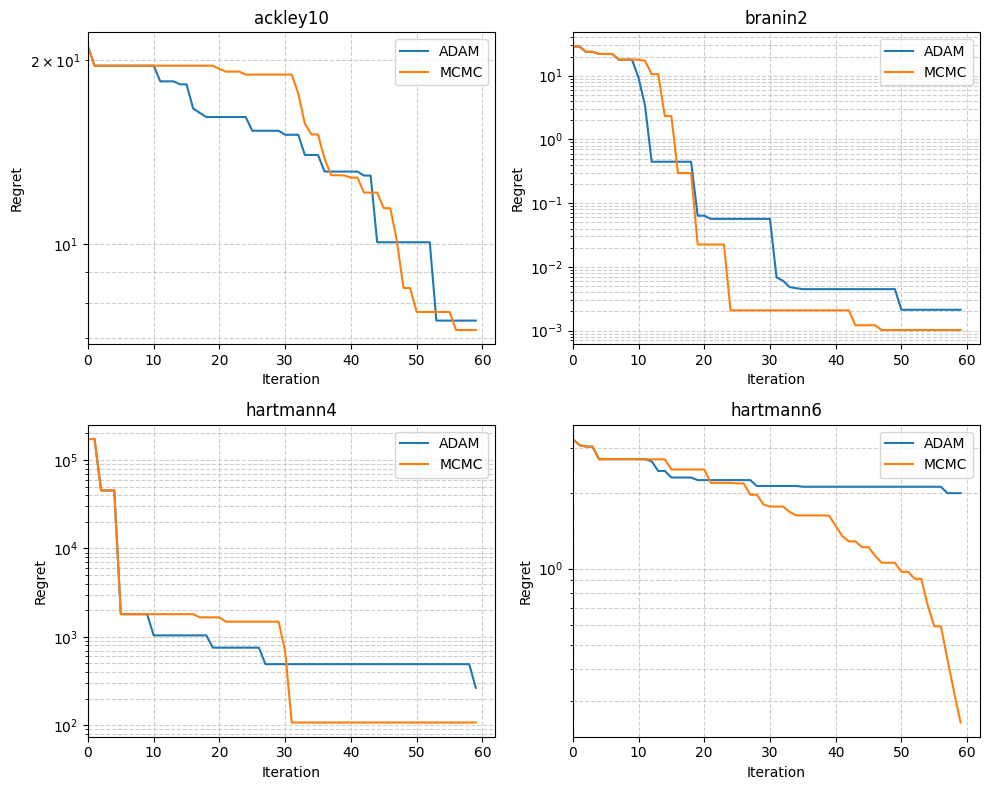

In [12]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Path to your data
data_dir = 'data/notebook_plot_data/'
files = os.listdir(data_dir)

# Group files by target name (before underscore)
groups = {}
for f in files:
    if not f.endswith('.pkl'):
        continue
    target = f.split('_')[0]  # e.g. 'ackley10'
    method = f.split('_')[1].split('.')[0]  # e.g. 'ADAM' or 'MCMC'
    groups.setdefault(target, {})[method] = os.path.join(data_dir, f)

# Sort targets to keep plots consistent
targets = sorted(groups.keys())

# Create subplots — 2x2 grid, no shared axes
n_targets = len(targets)
rows = cols = int(np.ceil(np.sqrt(n_targets)))
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))

axes = axes.flatten()

for i, (target, methods) in enumerate(groups.items()):
    ax = axes[i]
    for method, path in methods.items():
        with open(path, 'rb') as f:
            data = pickle.load(f)
        regret = np.array(data['regret'])
        ax.plot(regret, label=method)

    ax.set_title(target)
    ax.set_yscale('log')
    ax.set_xlabel('Iteration')
    ax.set_xlim(left=0)
    ax.set_ylabel('Regret')
    ax.legend()
    ax.grid(True, which='both', ls='--', alpha=0.6)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Discussion of Results

The graphed results loosley support existing literature that a bayesian treatment of the hyperparameters of a GP leads to better evaluations of synthetic test functions. Although this conslusion cannot be drawn with any certainty from just these graphs given that they show only one run of each BO loop for each target-optimizer pair, for full evidence of MCMC outperforming non bayesian methods see, with averaged results see \ref{}